# Subjectivity analysis
Use [subjective/objective movie review data](https://www.cs.cornell.edu/people/pabo/movie-review-data/) to train a classifier to filter out objective sentences as a preprocessing step to sentiment analysis.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm", exclude=["ner"]) # change to large model in the final execution
# nlp2 = spacy.load("en_core_web_lg", exclude=["ner"])

## Load and label data
The data of reviews are assumed to be subjective, and the plot descriptions are assumed to be objective.

In [2]:
subjective_df = pd.read_csv('subjectivity_data/plot.tok.gt9.5000', encoding='ISO-8859-1', #alternatively 'latin-1'
                            sep='\n', header=None, names=['sentence'])
objective_df  = pd.read_csv('subjectivity_data/quote.tok.gt9.5000', encoding='ISO-8859-1', #alternatively 'latin-1'
                            sep='\n', header=None, names=['sentence'])
subjective_df['label'] = 1
objective_df['label'] = 0

In [3]:
data = pd.concat([objective_df, subjective_df], ignore_index=False)
data.head()

,sentence,label
0,"smart and alert , thirteen conversations about...",0
1,"color , musical bounce and warm seas lapping o...",0
2,it is not a mass-market entertainment but an u...,0
3,a light-hearted french film about the spiritua...,0
4,my wife is an actress has its moments in looki...,0


Split data into train and test sets

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(data.sentence, data.label,
                                                                              test_size=0.3, random_state=100)

In [63]:
doc = nlp(train_sentences.iloc[4])
sentences_ = ' '.join([s.lemma_ for s in doc])
print(sentences_)

fresh from a series of emotional trauma , allison be distrustful and not so easily rescue , though over a period of two day she come to regard her idealization of dylan as a last opportunity for security and happiness .


Should non-alphanumeric characters be removed here as well? (punctuation should not matter too much)

Perhaps stop words should not be checked since there are domain specific words

In [6]:
def doc_preprocessor(text):
    """
    Preprocessor that returns a list of lemmas of a given text
    
    Input:
        - text: string that contains the text to be preprocessed
        
    Output:
        - tokens: a list of strings (lemmas)
    """
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]
    #tokens = [token.text for token in doc]
    return tokens

In [58]:
train_sentences.iloc[4]

'fresh from a series of emotional traumas , allison is distrustful and not so easily rescued , though over a period of two days she comes to regard her idealization of dylan as a last opportunity for security and happiness . '

Use binary vectorizer

In [7]:
# SET doc_preprocessor AS THE tokenizer ATTRIBUTE IN THE COUNT VECTORIZER TO USE IT
bin_vectorizer = CountVectorizer(strip_accents=None, lowercase=True,
                                 preprocessor=None, tokenizer=doc_preprocessor,
                                 stop_words=None, ngram_range=(1, 1),
                                 binary=False)

In [ ]:
bin_vectorizer.fit(data.sentence)

In [11]:
train_vec = bin_vectorizer.transform(train_sentences)
test_vec  = bin_vectorizer.transform(test_sentences)

## Train a naïve Bayes classifier
Predict on the test set

In [12]:
m_naive_bayes = MultinomialNB()
m_naive_bayes.fit(train_vec, train_labels)
te_pred = m_naive_bayes.predict(test_vec)

In [14]:
con_mat = classification_report(test_labels, te_pred)

In [15]:
print(con_mat)

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1495
           1       0.91      0.90      0.91      1505

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In [12]:
# Without preprocessing:
print(con_mat)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1495
           1       0.92      0.90      0.91      1505

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



OK! Use the predicted labels of the sentences to decide which are subjective and objective respectively. The subjective sentences can be used for polarity prediction.

# Graph-based subjectivity classification
Method adopted from [A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts by Pang and Lee](https://arxiv.org/abs/cs/0409058). Use proximity information to decide if a sentence should be classified as subjective or objective. Use the naïve Bayes classifier probabilities as weights in a graph and find the minimum cut to separate objective from subjective sentences.

The weights from the source to a sentence is the probability of the sentence being objective (1), and from a sentence to the sink the weight is the probability of the sentence being subjective (0).

Use the package `networkx` for running the min-cut algorithm [`networkx.algorithms.flow.minimum_cut`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.minimum_cut.html).

In [16]:
prob = m_naive_bayes.predict_proba(test_vec)

In [17]:
print(prob)
print(te_pred)

[[2.10820485e-01 7.89179515e-01]
 [1.45190594e-04 9.99854809e-01]
 [9.99938962e-01 6.10382582e-05]
 ...
 [9.99240041e-01 7.59958892e-04]
 [1.00000000e+00 1.32711468e-11]
 [9.78859278e-01 2.11407219e-02]]
[1 1 0 ... 0 0 0]


In [18]:
to_source = prob[:,0] # objective probability
to_sink = prob[:,1]   # subjective probability

Use an associative weight between sentence nodes $assoc(s_i,s_j) = c\cdot f(j-i) $ for $j-1 \leq T$ and $0$ otherwise, where $f(d)$ is decreasing. Pang and Lee used $c\in[0,1]$ with steps of $0.1$, $T\in\{1,2,3\}$, and $f(d)\in\{1, e^{1-d}, 1/d^2\}$.

In [55]:
def get_assoc_matrix(n_sentences, threshold=3, c=0.5):
    """
    Returns the weight matrix for the nodes
    Input:
        - n_sentences: the number of sentences in the review
        - threshold: the number of sentences that count as being close
        - c: weight (for each class) of the associative function
    """
    A = np.zeros((n_sentences,n_sentences))
    
    for i in range(n_sentences):
        for j in range(i+1, n_sentences):
            if j-i <= threshold:
                d = j-i
                A[i,j] = c*np.exp(1-d)
                A[j,i] = c*np.exp(1-d)
    return A


def get_graph_matrix(n_sentences, obj_prob, subj_prob, threshold=3, c=0.5):
    """
    Produces the (undirected) adjeacency matrix for the proposed
    minimum cut problem.
    
    Input:
        - n_sentences: number of sentences in the review
        - obj_prob: probabilities that the sentence is classified as objective
        - subj_prob: probabilities that the sentence is classified as subjective
        Used in the association matrix computation:
        - threshold: the number of sentences that count as being close
        - c: weight (for each class) of the associative function
        
    Output:
        - M: numpy array that represents the graph
    """
    
    A = get_assoc_matrix(n_sentences, threshold, c)
    
    M = np.zeros((n_sentences+2, n_sentences+2))
    M[1:n_sentences+1, 0] = obj_prob[0:n_sentences]
    M[0, 1:n_sentences+1] = obj_prob[0:n_sentences]

    M[n_sentences+1, 1:n_sentences+1] = subj_prob[0:n_sentences]
    M[1:n_sentences+1, n_sentences+1] = subj_prob[0:n_sentences]

    M[1:n_sentences+1, 1:n_sentences+1] = A
    
    return M


def get_mincut_predictions(reviews, vectorizer, subjectivity_clf):
    """
    Returns the subjective sentence prediction based on the minimum cut method.
    
    Input:
        - sentences: the sentences to be predicted
        - vectorizer: vectorizer object such as CountVectorizer
        - subjectivity_clf: classifier object that predicts the subjectivity
        of a single sentence.
    
    Output:
        - pred: a vector indicating objective (0) and subjective (1) sentences
    """
    pass
    


__N.B. In the example below we use sentences that are _not_ close to each other, and the classification will _not_ be improved here as a result.__

In [59]:
M = get_graph_matrix(n_sentences = 8)
print(np.around(M,3))

[[0.    0.211 0.    1.    1.    0.942 1.    1.    1.    0.   ]
 [0.211 0.    0.5   0.184 0.068 0.    0.    0.    0.    0.789]
 [0.    0.5   0.    0.5   0.184 0.068 0.    0.    0.    1.   ]
 [1.    0.184 0.5   0.    0.5   0.184 0.068 0.    0.    0.   ]
 [1.    0.068 0.184 0.5   0.    0.5   0.184 0.068 0.    0.   ]
 [0.942 0.    0.068 0.184 0.5   0.    0.5   0.184 0.068 0.058]
 [1.    0.    0.    0.068 0.184 0.5   0.    0.5   0.184 0.   ]
 [1.    0.    0.    0.    0.068 0.184 0.5   0.    0.5   0.   ]
 [1.    0.    0.    0.    0.    0.068 0.184 0.5   0.    0.   ]
 [0.    0.789 1.    0.    0.    0.058 0.    0.    0.    0.   ]]


In [23]:
import networkx as nx
from networkx.algorithms.flow import minimum_cut
G = nx.convert_matrix.from_numpy_matrix(M)

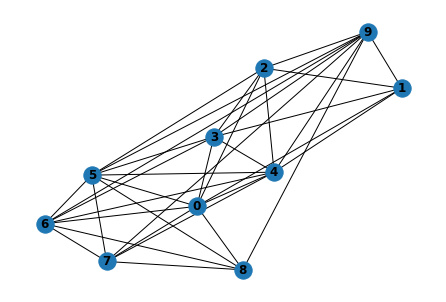

In [24]:
nx.draw(G, with_labels=True, font_weight='bold')

In [25]:
cut_value, partition = minimum_cut(flowG = G, _s=0, _t=n_sentences+1, capacity='weight')

In [26]:
print(test_sentences[0:8])

3018    the killer is getting closer , revealing more ...
4225    may is a young strange girl who had a very dis...
3854    ms . bennett is worth watching , and her story...
2029    the film jolts the laughs from the audience--a...
3539    the wild thornberrys movie has all the sibling...
1942    claude miller airs out a tight plot with an ea...
1250    one of [jaglom's] better efforts -- a wry and ...
2817    it may not be history  but then again , what ...
Name: sentence, dtype: object


In [27]:
print(partition)
print(te_pred[0:8])

({0, 3, 4, 5, 6, 7, 8}, {9, 2, 1})
[1 1 0 0 0 0 0 0]


Sanity check: We disregard the sink and source nodes 0 and 9, and find node 1 and 2 being objective, and the rest subjective, just like we had with the NB classifier. If the emphasis on proximity is increased (e.g. increase $c$ or $T$), the partition might change.

# Classification of reviews
### Read reviews and filter out objective sentences.

We begin by reading the data from the IMDb data set.

In [97]:
def read_folder(folder_path):
    file_paths = os.listdir(folder_path)
    review = []
    for filename in file_paths:
        with open(f'{folder_path}/{filename}', mode='r', encoding="utf8") as file:
            review.append(file.readline())
    return review, file_paths


def load_data():
    tr_pos_review, _ = read_folder('aclImdb/train/pos')
    tr_neg_review, _ = read_folder('aclImdb/train/neg')
    te_pos_review, _ = read_folder('aclImdb/test/pos')
    te_neg_review, _ = read_folder('aclImdb/test/neg')
    
    tr_reviews_pos = pd.DataFrame(tr_pos_review, columns=['review'])
    tr_reviews_pos['polarity'] = 1
    tr_reviews_neg = pd.DataFrame(tr_neg_review, columns=['review'])
    tr_reviews_neg['polarity'] = 0
    
    tr_reviews = tr_reviews_pos.append(tr_reviews_neg, ignore_index=True)
    
    te_reviews_pos = pd.DataFrame(te_pos_review, columns=['review'])
    te_reviews_pos['polarity'] = 1
    te_reviews_neg = pd.DataFrame(te_neg_review, columns=['review'])
    te_reviews_neg['polarity'] = 0
    
    te_reviews = te_reviews_pos.append(te_reviews_neg, ignore_index=True)
    
    return tr_reviews, te_reviews

In [98]:
tr_reviews, te_reviews = load_data()

In [99]:
tr_reviews.shape

(25000, 2)

#### Functions for filtering out the subjective sentences

Use spacy for preprocessing: lemmatization (and stop word removal?). We cannot use splitting on '.' as a proxy for sentence spans since initials like J.F. Kennedy will split a sentence in three parts.

In [100]:
def get_subjective_sentences(sentences, subj_pred, subj_value = 0):
    """
    Returns a string of sentences that is the concatenation of the
    subjective sentences according to predictions.
    
    Input:
        - sentences: list of strings that contain the sentences
        on which subjectivity detection was performed
        - subj_pred: predictions for each of the sentences (binary vector)
        - subj_value: the value of subjective sentences (0 or 1)
        
    Output:
        - sentence: the concatenation of all subjective sentences
    """
    sentence = ''
    for i, p in enumerate(subj_pred):
        if p == subj_value:
            sentence += sentences[i]
            sentence += ' '
    return sentence


def subjectivity_filter(df, filtering_clf, vectorizer):
    """
    Produces a data frame of subjective sentences from a data frame
    of sentences that are mixed subjective/objective.
    
    Input:
        - df: a data frame with columns 'review' and 'polarity'
        - vectorizer: vectorizer object such as CountVectorizer
        - filtering_clf: classifier object that predicts the subjectivity
        of a single sentence.
        
    Output:
        - subj_df: a data frame where the objective sentences have been
        filtered out.
    """
    
    subjective_sentences = []
    
    for row in df.itertuples():
        doc = nlp(row.review)
        sentences = [s.text for s in doc.sents]
        sentences_lemmatized = [' '.join(doc_preprocessor(s)) for s in sentences]
    
        sentences_vec = vectorizer.transform(sentences_lemmatized)
        subj_pred = filtering_clf.predict(sentences_vec)
        
        # Return sentences with or without lemmatizing?
        subj_sent = get_subjective_sentences(sentences, subj_pred)
        
        subjective_sentences.append(subj_sent)
    
    subj_df = pd.DataFrame(subjective_sentences, columns=['review'])
    subj_df['polarity'] = df['polarity']
    
    return subj_df
    

In [101]:
df_tr_filtered = subjectivity_filter(tr_reviews, m_naive_bayes, bin_vectorizer)
df_te_filtered = subjectivity_filter(te_reviews, m_naive_bayes, bin_vectorizer)

In [102]:
df_tr_filtered.head()

,review,polarity
0,Bromwell High is a cartoon comedy. I expect th...,1
1,That is Goddard Bolt's lesson.<br /><br />Mel ...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [103]:
df_tr_filtered.shape

(25000, 2)

We instantiate a new vectorizer for the sentiment prediction data, and then train the classifier and predict on the test set

In [104]:
sentiment_vectorizer = CountVectorizer(strip_accents=None, lowercase=True,
                                       preprocessor=None, tokenizer=doc_preprocessor,
                                       stop_words=None, ngram_range=(1, 1),
                                       binary=False)

In [105]:
# Vectorizer should take training data only
train_vec_polarity = sentiment_vectorizer.fit_transform(df_tr_filtered.review)
train_lab_polarity = df_tr_filtered.polarity

test_vec_polarity = sentiment_vectorizer.transform(df_te_filtered.review)
test_lab_polarity = df_te_filtered.polarity

In [ ]:
polarity_nb = MultinomialNB()
polarity_nb.fit(train_vec_polarity, train_lab_polarity)

In [107]:
te_pred_polarity = polarity_nb.predict(test_vec_polarity)

In [108]:
clf_report = classification_report(test_lab_polarity, te_pred_polarity)

In [109]:
print(clf_report)

              precision    recall  f1-score   support

           0       0.80      0.87      0.84     12500
           1       0.86      0.79      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

